# Shap Value Visualization for Blog Post

In [82]:
## Import Numpy and set random seed for notebook
import numpy as np
np.random.seed(319)

## Import functions made specifically for this project
from capstone_functions import *
import plotly_year_functions as pyy

## Import remaining necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import plotly.express as px

In [83]:
## Set options for displaying Pandas DataFrames
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

## Obtain 2020 Election

In [84]:
## Import and preview dataset
elec_2020_df = pd.read_csv('Data/UC_gen_2020_clean.gz',
                     dtype={'precinct_abbrv': str, 
                            'vtd_abbrv': str
                             })
elec_2020_df.head()

ncid  no_vote_his  birth_age_adj     voting_method Gen_2020  \
0  AA100547            0           65.0  ABSENTEE ONESTOP    Early   
1  AA108801            0           57.0           No Vote  No Vote   
2  AA109481            0           47.0  ABSENTEE ONESTOP    Early   
3  AA112504            0           72.0           No Vote  No Vote   
4  AA114763            0           53.0  ABSENTEE ONESTOP    Early   

   vote_early  vote_by_mail  vote_curbside      Pri_2020 party_cd gender_code  \
0         1.0           0.0            0.0  Election Day      REP           M   
1         0.0           0.0            0.0       No Vote      UNA           M   
2         1.0           0.0            0.0       No Vote      DEM           F   
3         0.0           0.0            0.0       No Vote      REP           F   
4         1.0           0.0            0.0  Election Day      DEM           F   

   birth_year  registr_dt race_code ethnic_code  zip_code  \
0        1955  2014-03-31         W          UN   28079.0   
1        1963  2016-11-04         W          NL   28173.0   
2        1973  2020-03-19         W          NL   28173.0   
3        1948  2012-10-26         W          NL   28112.0   
4        1967  2012-08-13         B          UN   28104.0   

            res_street_address res_city_desc birth_state drivers_lic  \
0          5514  BEVERLY DR     INDIAN TRAIL          NC           Y   
1      4221  OXFORD MILL RD           WAXHAW          MA           Y   
2          1013  LYDNEY CIR           WAXHAW          MN           Y   
3        4325  WOLF POND RD           MONROE          NY           Y   
4  4002  LAWRENCE DANIEL DR         MATTHEWS          NC           Y   

  precinct_abbrv vtd_abbrv  cong_dist_abbrv super_court_abbrv  \
0            016       016              9.0               20B   
1           020B      020B              9.0               20B   
2           020A      020A              9.0               20B   
3            024       024              9.0               20B   
4           037A      037A              9.0               20B   

  judic_dist_abbrv  nc_senate_abbrv  nc_house_abbrv  school_dist_abbrv  \
0              20C             35.0            69.0                4.0   
1              20C             35.0            68.0                6.0   
2              20C             35.0            68.0                2.0   
3              20C             35.0            55.0                2.0   
4              20C             35.0            69.0                5.0   

   drivers_lic_bin vote_cat  Gen_2020_binary  Pri_2020_binary party_grp  \
0                1    Early                1                1       Rep   
1                1  No Vote                0                0     Other   
2                1    Early                1                0       Dem   
3                1  No Vote                0                0       Rep   
4                1    Early                1                1       Dem   

  race_grp      city_grp birth_reg_other generation gen_grp  
0    White  Indian Trail           South     Boomer  Boomer  
1    White        Waxhaw       Northeast     Boomer  Boomer  
2    White        Waxhaw         Midwest       GenX    GenX  
3    White        Monroe       Northeast     Boomer  Boomer  
4    Black      Matthews           South       GenX    GenX

# MODEL

**Overview of the process for modeling registered voter participation for each election year:** 
- Predictive features used for all models:
 - **Generation** (`gen_grp`) - Based on birth year: Gen Z, Millennial, Generation X, Baby Boomer, Greatest-Silent (combined the two oldest generations together)
 - **Political Party** (`party_grp`) - Democrat, Republican, or Other (includes voters registered as unaffiliated, Libertarian, Green, or Constitution)
 - **Race** (`race_grp`) - Black, White, Undesignated, or Other (includes voters that identify with 2 or more racial groups, Asian, Native American, Pacific Islander, or other groups)
 - **Gender** (`gender_code`) - Female, Male, or Undesignated
 - **Birth Region** (`birth_reg_other`) - Broken into U.S. Census regions (South, Northeast, Midwest, West), Missing, and other (including U.S. territories and citizens born outside the U.S.)
 - **Drivers License** (`drivers_lic`) - Whether or not the person possesses a drivers license
 - **City** (`city_grp`) - Cities within Union County: Monroe, Matthews, Waxhaw, Indian Trail, Other (includes all other cities/ towns within the county)
<br><br>
 
- Model voter participation as a binary target (Vote vs. No Vote):
 - Train and test Random Forest Classifiers (scikit-learn) with and without SMOTE for oversampling to address class imbalance.
 - Train and test XGBoost Classifiers (xgboost) with and without using `scale_pos_weight` hyperparameter to balance classes.
 - Tune model hyperparameters using GridSearchCV.
<br><br>

- Model voter participation as a multiclass target (Early, Election Day, or No Vote):
 - Train and test Random Forest Classifiers (scikit-learn) with and without SMOTE for oversampling to address class imbalance.
 - Train and test XGBoost Classifiers (xgboost) with and without SMOTE for oversampling to address class imbalance.
 - Tune model hyperparameters using GridSearchCV.
<br><br>

- Binary and multiclass target models for the same year were trained using the same train-test split of the data.

---
**Summary of model performance across election years:**
- Random Forest Classifiers and XGBoost Classifiers performed relatively similary for all years, but XGBoost tended to result in slightly higher overall accuracy across classes.
- Addressing class imbalances either via SMOTE or by making use of XGBoost's `scale_pos_weight` hyperparameter was necessary to improve the performance of all models.
- Across years, binary target model accuracy of the best models maxed out around 67% overall accuracy and the best multiclass models maxed out at around 50% overall accuracy.

In [85]:
## Import necessary functions/methods/classes for modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve

## Import classes necessary for building preprocessing pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

## Import necessary libraries for SMOTE
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

<a id='mod_2020'></a>
## Model 2020 Election

### 2020 Binary Target - Vote vs. No Vote

#### 2020 Prepare DataFrame for Modeling - Train Test Split and Preprocessing

In [86]:
## Create new DataFrame from the full cleaned df that only consists of 
  ## the target ('Gen_2020') and desired predictors
model_2020_df = elec_2020_df.copy()
model_2020_df = model_2020_df[['Gen_2020', 'Gen_2020_binary', 'gen_grp', 'party_grp',
                     'race_grp', 'gender_code', 'birth_reg_other',
                     'drivers_lic', 'city_grp']]

## Drop the 'Other' voting method so train-test-splits constant across
## binary and multiclass target models
  ## 'Other' represents provisional and transfer ballots. This type of
    ## vote is not so much generated by a voter's choice as it is by the 
    ## legal process of how votes may be cast.
model_2020_df = model_2020_df.drop(model_2020_df.loc[model_2020_df['Gen_2020']=='Other'].index)

## Inspect the resulting df
display(model_2020_df.head())
len(model_2020_df)

Gen_2020  Gen_2020_binary gen_grp party_grp race_grp gender_code  \
0    Early                1  Boomer       Rep    White           M   
1  No Vote                0  Boomer     Other    White           M   
2    Early                1    GenX       Dem    White           F   
3  No Vote                0  Boomer       Rep    White           F   
4    Early                1    GenX       Dem    Black           F   

  birth_reg_other drivers_lic      city_grp  
0           South           Y  Indian Trail  
1       Northeast           Y        Waxhaw  
2         Midwest           Y        Waxhaw  
3       Northeast           Y        Monroe  
4           South           Y      Matthews

167337

In [87]:
## Check class imbalance
check_unique('Gen_2020_binary', model_2020_df)

In [88]:
## Define target variable
bin_2020_target = 'Gen_2020_binary'

## Separate features (X) and target (y) for train-test-split
X_2020 = model_2020_df.drop(columns=[bin_2020_target, 'Gen_2020'], axis=1).copy()
y_bin_2020 = model_2020_df[bin_2020_target].copy()

## Define random seed to use for train-test-split and 
 ## classifiers for reproducibility
random_seed = 319

## Split the data into training and test sets prior to preprocessing
X_2020_train, X_2020_test, y_bin_2020_train, y_bin_2020_test = train_test_split(X_2020, y_bin_2020,
                                           test_size=0.25,
                                           random_state=random_seed)

## Make a list of all columns that are currently object dtype
cat_cols = list(X_2020_train.select_dtypes('O').columns)

## Create a pipeline for one hot encoding categorical columns
cat_transformer = Pipeline(steps = [
    ('ohe', OneHotEncoder(handle_unknown='error', 
                          sparse=False,
                          drop='if_binary'))])

## Define pipeline for preprocessing X
preprocessing = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_cols)
])

## Preprocess training and test predictors (X)
X_2020_train_tf = preprocessing.fit_transform(X_2020_train)
X_2020_test_tf = preprocessing.transform(X_2020_test)

## Get the feature names in the order they appear in preprocessed data
feature_names_2020 = preprocessing.named_transformers_['cat'].named_steps['ohe'].get_feature_names(cat_cols)
feature_names_2020

array(['gen_grp_Boomer', 'gen_grp_GenX', 'gen_grp_GenZ',
       'gen_grp_Greatest-Silent', 'gen_grp_Millennial', 'party_grp_Dem',
       'party_grp_Other', 'party_grp_Rep', 'race_grp_Black',
       'race_grp_Other', 'race_grp_Undesig.', 'race_grp_White',
       'gender_code_F', 'gender_code_M', 'gender_code_U',
       'birth_reg_other_Midwest', 'birth_reg_other_Missing',
       'birth_reg_other_Northeast', 'birth_reg_other_Other',
       'birth_reg_other_South', 'birth_reg_other_West', 'drivers_lic_Y',
       'city_grp_Indian Trail', 'city_grp_Matthews', 'city_grp_Monroe',
       'city_grp_Other', 'city_grp_Waxhaw'], dtype=object)

In [89]:
type(X_2020_train_tf)

numpy.ndarray

In [90]:
X_2020_train.head()

gen_grp party_grp  race_grp gender_code birth_reg_other drivers_lic  \
102965    GenZ     Other     White           F           South           Y   
99191     GenX     Other  Undesig.           U         Missing           N   
122222  Boomer     Other     White           F         Missing           Y   
28325     GenX     Other  Undesig.           U           South           Y   
115479    GenX       Rep     White           F           South           Y   

            city_grp  
102965  Indian Trail  
99191       Matthews  
122222        Monroe  
28325         Monroe  
115479         Other

#### 2020 Best Binary Target Model - XGBoost Classifier

##### 2020 Baseline Binary XGBoost

------------------------------------------------------------------------
Classification Report: Baseline 2020 Binary XGBoost with Default Params
------------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vote       0.61      0.07      0.13      9211
        Vote       0.79      0.99      0.88     32624

    accuracy                           0.79     41835
   macro avg       0.70      0.53      0.50     41835
weighted avg       0.75      0.79      0.71     41835

------------------------------------------------------------------------
------------------------------------------------------------------------




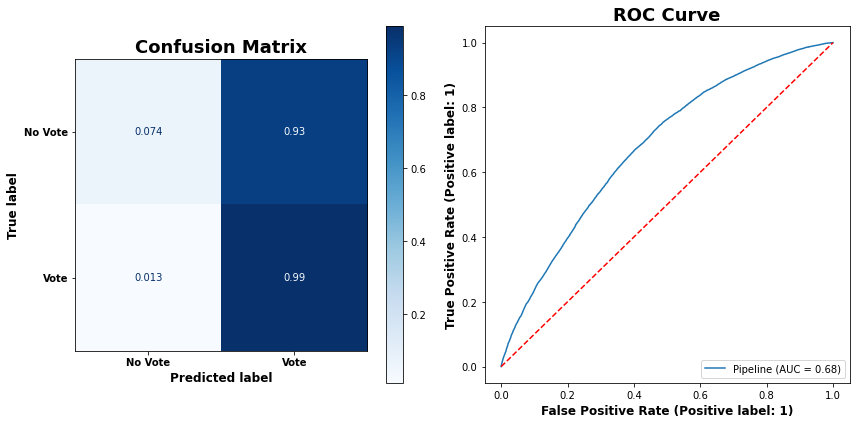

In [91]:
## Use preprocessor as the first step in modeling Pipeline 
xgb_bin_2020 = Pipeline(steps=[('preprocessing', preprocessing),
                      ('xgb', XGBClassifier(random_state=random_seed,
                                            objective='binary:logistic'))])

xgb_bin_2020.fit(X_2020_train, y_bin_2020_train)

eval_bin_clf(xgb_bin_2020, X_2020_test, y_bin_2020_test,
             model_descr='Baseline 2020 Binary XGBoost with Default Params');

##### 2020 Tuning Binary XGBoost Hyperparameters

------------------------------------------------------------
***** Grid Search Started at 02/26/21 - 15:17:51 PM
------------------------------------------------------------


***** Training Completed at 02/26/21 - 15:18:44 PM

***** Total Training Time: 0:00:53.224256


Best Parameters:
{'xgb__colsample_bytree': 0.8, 'xgb__eta': 0.1, 'xgb__max_delta_step': 1, 'xgb__max_depth': 6, 'xgb__scale_pos_weight': 0.28, 'xgb__subsample': 0.85}


------------------------------------------------------------------------
Classification Report: Best 2020 Binary XGB Tuned for Balanced Accuracy
------------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vote       0.34      0.58      0.43      9211
        Vote       0.85      0.69      0.76     32624

    accuracy                           0.66     41835
   macro avg       0.60      0.63      0.60     41835
weighted avg       0.74      0.66      0.69     41835

--------------

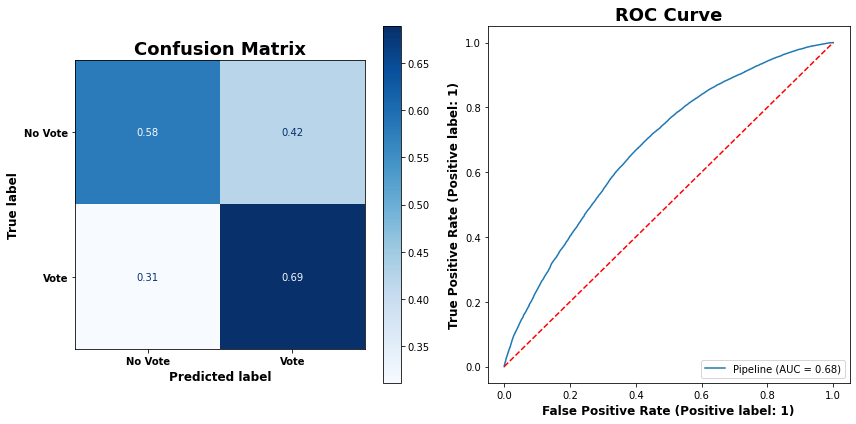

In [92]:
## Define a grid of different hyperparameter values to be tested
params = {
    'xgb__eta':[0.1],
    'xgb__max_depth':[6],
    'xgb__subsample': [0.85],
    'xgb__colsample_bytree': [0.8],
    'xgb__scale_pos_weight': [0.28],
    'xgb__max_delta_step': [1]
}

## run the grid search to test parameters and find the best estimator 
xgb_bin_2020_bacc_grid = fit_grid_clf(xgb_bin_2020, params,
                             X_2020_train, y_bin_2020_train,
                             X_2020_test, y_bin_2020_test,
                             model_descr='Best 2020 Binary XGB Tuned for Balanced Accuracy',
                             score='balanced_accuracy',
                             bin_target=True)

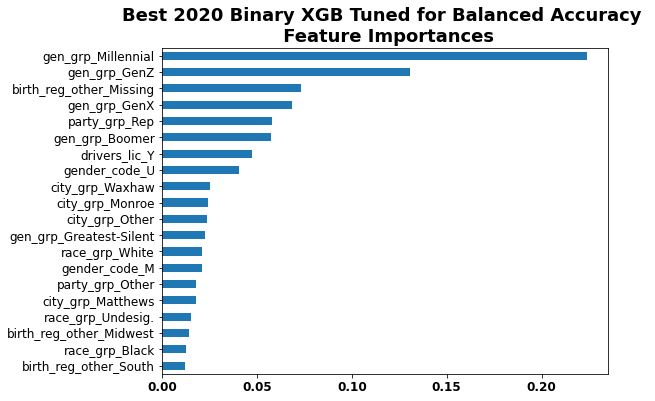

In [93]:
plot_feat_importance(xgb_bin_2020_bacc_grid.best_estimator_, 'xgb', feature_names_2020,
                     model_title='Best 2020 Binary XGB Tuned for Balanced Accuracy \n');

### 2020 Multiclass Target - Early, Election Day, No Vote

#### 2020 Prepare DataFrame for Modeling - Train Test Split and Preprocessing

In [94]:
## Inspect model_2020_df
display(model_2020_df.head())
len(model_2020_df)

Gen_2020  Gen_2020_binary gen_grp party_grp race_grp gender_code  \
0    Early                1  Boomer       Rep    White           M   
1  No Vote                0  Boomer     Other    White           M   
2    Early                1    GenX       Dem    White           F   
3  No Vote                0  Boomer       Rep    White           F   
4    Early                1    GenX       Dem    Black           F   

  birth_reg_other drivers_lic      city_grp  
0           South           Y  Indian Trail  
1       Northeast           Y        Waxhaw  
2         Midwest           Y        Waxhaw  
3       Northeast           Y        Monroe  
4           South           Y      Matthews

167337

In [95]:
## Check that only the 3 target classes that represent a voter's choice remain
check_unique('Gen_2020', model_2020_df)

In [96]:
## Define target variable
multi_2020_target = 'Gen_2020'

## Separate features (X) and target (y) for train-test-split
## X was already defined for previous models,
  ## only need to adjust for new target
y_multi_2020 = model_2020_df[multi_2020_target].copy()

## Split the data into training and test sets prior to preprocessing
  ## Random seed same as for binary modeling, so produces same X splits
X_2020_train, X_2020_test, y_multi_2020_train, y_multi_2020_test = train_test_split(X_2020,
                                                                y_multi_2020,
                                                                test_size=0.25,
                                                                random_state=random_seed)

## Preprocess training and test target (y)
le_2020 = LabelEncoder()
y_multi_2020_train = pd.Series(le_2020.fit_transform(y_multi_2020_train))
y_multi_2020_test = pd.Series(le_2020.transform(y_multi_2020_test))

## Check order of classes
le_2020.classes_

array(['Early', 'Election Day', 'No Vote'], dtype=object)

#### 2020 Best Multiclass Target Model - XGBoost with SMOTE

##### 2020 Baseline Multiclass XGBoost with SMOTE

-------------------------------------------------------------------------
Classification Report: 2020 Multiclass SMOTE XGBoost with Default Params
-------------------------------------------------------------------------
              precision    recall  f1-score   support

       Early       0.76      0.56      0.64     27591
Election Day       0.18      0.37      0.24      5033
     No Vote       0.38      0.46      0.42      9211

    accuracy                           0.51     41835
   macro avg       0.44      0.46      0.43     41835
weighted avg       0.61      0.51      0.54     41835

-------------------------------------------------------------------------
-------------------------------------------------------------------------




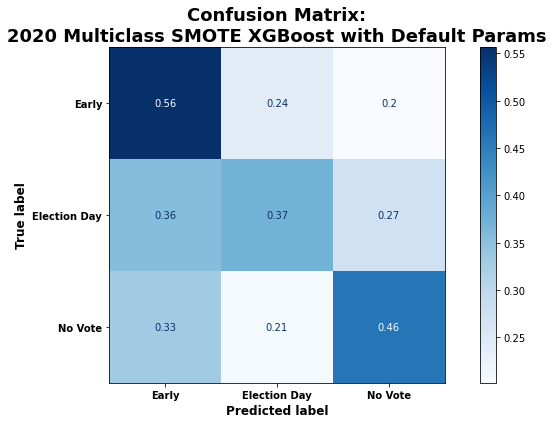

In [97]:
## Use preprocessor as the first step in modeling Pipeline,
  ## followed by SMOTE for oversampling
xgb_multi_2020_smote = imbPipeline(steps=[
    ('preprocessing', preprocessing),
    ('sampler', SMOTE(random_state=random_seed, n_jobs=-1)),
    ('xgb', XGBClassifier(random_state=random_seed))])

xgb_multi_2020_smote.fit(X_2020_train, y_multi_2020_train)

eval_classifier(xgb_multi_2020_smote, X_2020_test, y_multi_2020_test,
                model_descr='2020 Multiclass SMOTE XGBoost with Default Params');

##### 2020 Tuning Multiclass XGBoost with SMOTE Hyperparameters

------------------------------------------------------------
***** Grid Search Started at 02/26/21 - 15:20:47 PM
------------------------------------------------------------


***** Training Completed at 02/26/21 - 15:26:23 PM

***** Total Training Time: 0:05:36.032830


Best Parameters:
{'sampler__k_neighbors': 3, 'xgb__colsample_bytree': 0.8, 'xgb__eta': 0.1, 'xgb__max_delta_step': 1, 'xgb__max_depth': 6, 'xgb__subsample': 0.7}


----------------------------------------------------------------------------------
Classification Report: Best 2020 Multiclass SMOTE XGB Tuned for Balanced Accuracy
----------------------------------------------------------------------------------
              precision    recall  f1-score   support

       Early       0.76      0.53      0.63     27591
Election Day       0.18      0.40      0.24      5033
     No Vote       0.38      0.46      0.42      9211

    accuracy                           0.50     41835
   macro avg       0.44      0.46      0.43 

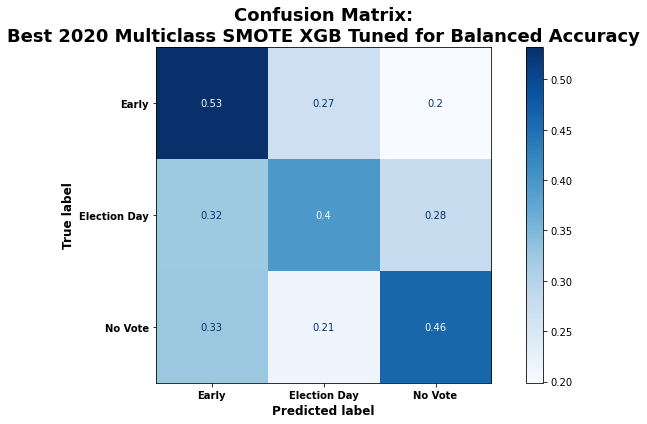

In [98]:
## Define a grid of different hyperparameter values to be tested
params = {
    'sampler__k_neighbors':[3],
    'xgb__eta':[0.1],
    'xgb__max_depth':[6],
    'xgb__subsample': [0.7],
    'xgb__colsample_bytree': [0.8],
    'xgb__max_delta_step': [1]
}

## run the grid search to test parameters and find the best estimator 
xgb_multi_2020_smote_bacc_grid = fit_grid_clf(xgb_multi_2020_smote, params,
                             X_2020_train, y_multi_2020_train,
                             X_2020_test, y_multi_2020_test,
                             model_descr='Best 2020 Multiclass SMOTE XGB Tuned for Balanced Accuracy',
                             score='balanced_accuracy')

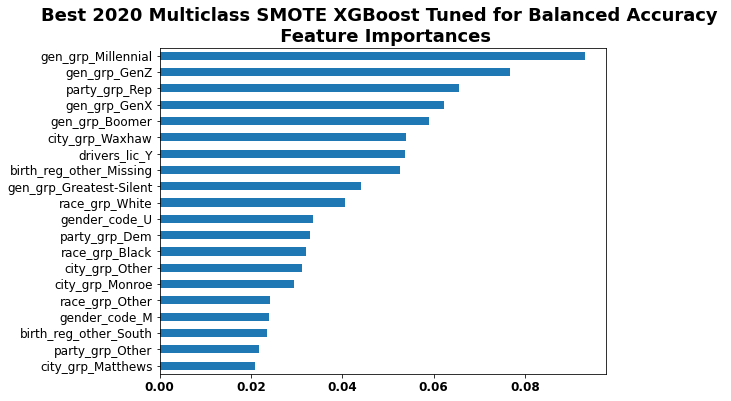

In [99]:
plot_feat_importance(xgb_multi_2020_smote_bacc_grid.best_estimator_, 'xgb', feature_names_2020,
                     model_title='Best 2020 Multiclass SMOTE XGBoost Tuned for Balanced Accuracy \n');

# INTERPRET

Once the best models were selected, the relationships of the top predictive features with the target variable were interpreted using SHAP (SHapley Additive exPlanations). Across all three election years, age group (generation), birth region, political party, and possession of a drivers license emerged as some of the top predictors of registered voter participation. These trends are explained in further detail for each election year in the following sections.

In [100]:
## Import necessary libraries
import xgboost
import shap

## Load JS visualization code to notebook
shap.initjs()

In [170]:
def shap_force(clf, clf_step_name, index, 
               X_train_df, y_train,
               explainer, shap_vals, save=False,
               fig_name=None):
    """Takes in a fitted classifier Pipeline, the name of the classifier step,
        the X training DataFrame, the y train array, a shap explainer, and the
        shap values to print the ground truth and predicted label and display
        the shap force plot for the record specified by index.

    Args:
        clf (estimator): An sklearn Pipeline with a fitted classifier as the final step.
        clf_step_name (str): The name given to the classifier step of the pipe.
        X_train_df (DataFrame): A Pandas DataFrame that from the train-test-split
            used to train the classifier, with column names corresponding to
            the feature names.
        y_train (series or array): Subset of y data used for training.
        index (int): The index of the observation of interest.
        explainer (shap explainer): A fitted shap.TreeExplainer object.
        shap_vals (array): The array of shap values.
        save (bool, default=False): Whether to save the returned figure. Defaults to False.
        fig_name (str, optional): What to name the file if the image is being saved.
            Defaults to None.

    Returns:
        Figure: Shap force plot showing the breakdown of how the model made
            its prediction for the specified record in the training set.
    """    

    import pandas as pd
    import shap
    
    fig_filepath = 'Figures/'

    ## Load JS visualization code to notebook
    shap.initjs()
    
    
    ## Store model prediction and ground truth label
    pred = clf.named_steps[clf_step_name].predict(X_train_df.iloc[index,:])
    true_label = y_train.iloc[index]
    
    
    ## Assess accuracy of prediction
    if true_label == pred:
        accurate = 'Correct!'
    else:
        accurate = 'Incorrect'
    
    
    ## Print output that checks model's prediction against true label
    print('***'*12)
    # Print ground truth label for row at index
    print(f'Ground Truth Label: {true_label}')
    print()
    # Print model prediction for row at index
    print(f'Model Prediction:  {pred} -- {accurate}')
    print('***'*12)
    print()
    
    ## If saving the file 
    if save:
        
        shap.force_plot(explainer.expected_value,
                        shap_vals[index,:],
                        X_train_df.iloc[index,:],
                        show=False, matplotlib=True).savefig(
            fig_filepath+fig_name, bbox_inches = "tight"
        )
        
        print('Figure image saved.')
    
    
    ## Display the prediction's explanation
    fig = shap.force_plot(explainer.expected_value,
                              shap_vals[index,:],
                              X_train_df.iloc[index,:])
    
    
    return fig

<a id='int_2020'></a>
## Interpret 2020 Election

In [132]:
## Convert transformed (preprocessed) X train set into pandas DataFrame
X_2020_train_df = pd.DataFrame(X_2020_train_tf, columns=feature_names_2020)
X_2020_train_df.head()

gen_grp_Boomer  gen_grp_GenX  gen_grp_GenZ  gen_grp_Greatest-Silent  \
0             0.0           0.0           1.0                      0.0   
1             0.0           1.0           0.0                      0.0   
2             1.0           0.0           0.0                      0.0   
3             0.0           1.0           0.0                      0.0   
4             0.0           1.0           0.0                      0.0   

   gen_grp_Millennial  party_grp_Dem  party_grp_Other  party_grp_Rep  \
0                 0.0            0.0              1.0            0.0   
1                 0.0            0.0              1.0            0.0   
2                 0.0            0.0              1.0            0.0   
3                 0.0            0.0              1.0            0.0   
4                 0.0            0.0              0.0            1.0   

   race_grp_Black  race_grp_Other  race_grp_Undesig.  race_grp_White  \
0             0.0             0.0                0.0             1.0   
1             0.0             0.0                1.0             0.0   
2             0.0             0.0                0.0             1.0   
3             0.0             0.0                1.0             0.0   
4             0.0             0.0                0.0             1.0   

   gender_code_F  gender_code_M  gender_code_U  birth_reg_other_Midwest  \
0            1.0            0.0            0.0                      0.0   
1            0.0            0.0            1.0                      0.0   
2            1.0            0.0            0.0                      0.0   
3            0.0            0.0            1.0                      0.0   
4            1.0            0.0            0.0                      0.0   

   birth_reg_other_Missing  birth_reg_other_Northeast  birth_reg_other_Other  \
0                      0.0                        0.0                    0.0   
1                      1.0                        0.0                    0.0   
2                      1.0                        0.0                    0.0   
3                      0.0                        0.0                    0.0   
4                      0.0                        0.0                    0.0   

   birth_reg_other_South  birth_reg_other_West  drivers_lic_Y  \
0                    1.0                   0.0            1.0   
1                    0.0                   0.0            0.0   
2                    0.0                   0.0            1.0   
3                    1.0                   0.0            1.0   
4                    1.0                   0.0            1.0   

   city_grp_Indian Trail  city_grp_Matthews  city_grp_Monroe  city_grp_Other  \
0                    1.0                0.0              0.0             0.0   
1                    0.0                1.0              0.0             0.0   
2                    0.0                0.0              1.0             0.0   
3                    0.0                0.0              1.0             0.0   
4                    0.0                0.0              0.0             1.0   

   city_grp_Waxhaw  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

### 2020 Binary Target Model

In [104]:
## Store the booster (trained model)
bin_2020_est = xgb_bin_2020_bacc_grid.best_estimator_
bin_2020_model = bin_2020_est.named_steps['xgb'].get_booster()

In [105]:
## Explain the model's predictions using SHAP
bin_2020_explainer = shap.TreeExplainer(bin_2020_model)
bin_2020_shap_values = bin_2020_explainer.shap_values(X_2020_train_df)

In [171]:
## Print model prediction, true label, and shap force plot for seventh row
  ## of training set
shap_force(bin_2020_est,
           'xgb',
           6,
           X_2020_train_df, 
           y_bin_2020_train, 
           bin_2020_explainer, 
           bin_2020_shap_values)

************************************
Ground Truth Label: 0

Model Prediction:  [0] -- Correct!
************************************



The plot above visualizes how the model is making its prediction for the seventh individual in the training set. 
> The seventh individual did not vote and the model predicted this correctly. The model was pushed towards the prediction of "no vote" by the fact that the individual belongs to Gen Z (and thus is also neither in Generation X or a Baby Boomer). The fact that the individual was male and not a Republican also pushed the model towards the correct prediction for this individual. The facts that he lives in Matthews and is not a millennial pushed the model in the opposite direction, but not enough to overwhelm the factors more predictive of "no vote" (0).

In [172]:
## Print model prediction, true label, and shap force plot for third row
  ## of training set

shap_force(bin_2020_est, 
           'xgb',
           2,
           X_2020_train_df, 
           y_bin_2020_train, 
           bin_2020_explainer, 
           bin_2020_shap_values)

************************************
Ground Truth Label: 1

Model Prediction:  [1] -- Correct!
************************************



The plot immediately above visualizes how the model is making its prediction for the third individual in the training set. 
> The third individual voted and the model predicted this correctly. The model was pushed towards the prediction of "vote" (1) by the fact that their birth region information was missing, they belong to the Baby Boomer generation (and thus are not a millenial), and they have a drivers license. The fact the this person is not a Republican and also chose not to identify as being affiliated with either of the two major political parties pushed the model in the incorrect direction towards "no vote" (0), but not enough to overwhelm the factors more predictive of "vote" (1).

In [152]:
## Print model prediction, true label, and shap force plot for first row
  ## of training set
shap_force(bin_2020_est, 
           'xgb',
           0,
           X_2020_train_df, 
           y_bin_2020_train, 
           bin_2020_explainer, 
           bin_2020_shap_values)

************************************
Ground Truth Label: 1

Model Prediction:  [0] -- Incorrect
************************************



The plot below shows the impact each feature had on the model's output (predictions) quantified in terms of SHAP values. The top 7 features (after which there is a drop in impact) are `gen_grp_Millennial`, `birth_reg_other_Missing`, `party_grp_Rep`, `gen_grp_Boomer`, `gen_grp_GenX`, `gen_grp_GenZ`, and `drivers_lic_Y`. Obviously age group is important because it makes up 4 of the top 7 features. Only the oldest age group (really two oldest generations combined as 'Greatest-Silent') is missing. Whether or not a person's voter registration record lists their birthplace is the second most impactful feature on model output, and whether or not the voter registered as a Republican is the third most impactful feature. Whether or not the person possesses a drivers license was the 7th most impactful predictor.

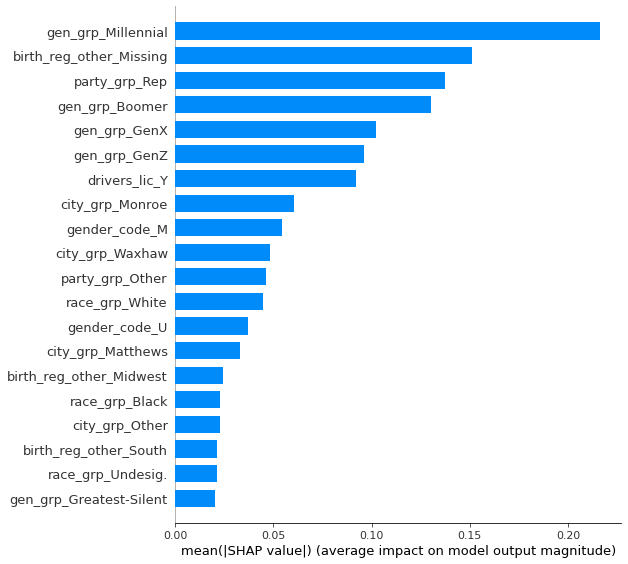

In [108]:
## Display mean abs(SHAP value) for each feature for the full training set
shap.summary_plot(bin_2020_shap_values, X_2020_train_df, plot_type='bar')

The plot below is similar to that above in that it ranks the top features based on mean SHAP values (so the ordering is the same). Each point represents a voter in the training set. The grey vertical line at 0.0 represents SHAP values that had 0 impact on model output, so the farther the points are from the grey line, the more important the feature was in terms of predicting that voter's participation in the election (whether they voted or not). Negative SHAP values to the left of the grey line push the model towards a prediction of 0 or "No Vote" whereas positive SHAP values push the model towards a prediction of 1 or "Vote". 

Since all the features were label encoded, each feature is a binary variable representing whether the voter does or does not belong to the category listed at the end of the feature name (so 1 for `gen_grp_Millenial` means the person is a millennial). Thus high values of 1 are color coded red and low values of 0 are color coded blue.

**Top 7 Features Explained**:

1. `gen_grp_Millennial` - Being a millenial (1, red) pushed the model towards a prediction of "No Vote".


2. `birth_reg_other_Missing` - Voters whose record was missing their birthplace information (1, red) were more likely to vote.


3. `party_grp_Rep` - Being a Republican (1, red) pushed the model towards a prediction of "Vote".


4. `gen_grp_Boomer` - Belonging to the Baby Boomer generation (1, red) pushed the model towards a prediction of "Vote".


5. `gen_grp_GenX` - Belonging to the Generation X (1, red) pushed the model towards a prediction of "Vote".


6. `gen_grp_GenZ` - Belonging to the Gen Z (1, red) pushed the model towards a prediction of "No Vote".


7. `drivers_lic_Y` - Not having a drivers license (0, blue) made the model predict that someone was less likely to vote.

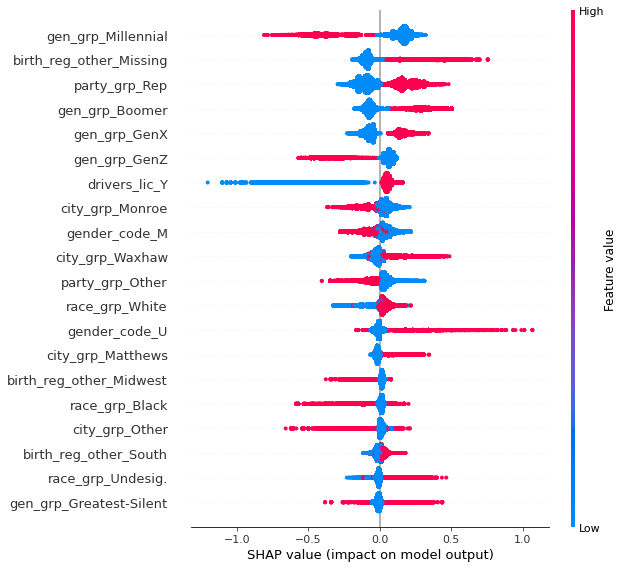

In [109]:
## Display mean abs(SHAP value) for each feature for the full training set
shap.summary_plot(bin_2020_shap_values, X_2020_train_df)

### 2020 Multiclass Target Model

In [163]:
def multi_shap_force(clf, clf_step_name, index,
                     X_train_df, y_train,
                     explainer, multi_shap_vals,
                     classes='all'):
    """Takes in a fitted classifier Pipeline, the name of the classifier step,
        the X training DataFrame, the y train array, a shap explainer, and the
        multiclass shap values. Prints the ground truth and predicted label for
        the record of interest and displays shap force plots of the desired classes
        for the record specified by index.

    Args:
        clf (estimator): An sklearn Pipeline with a fitted classifier as the final step.
        clf_step_name (str): The name given to the classifier step of the pipe.
        index (int): The index of the observation of interest.
        X_train_df (DataFrame): A Pandas DataFrame that from the train-test-split
            used to train the classifier, with column names corresponding to
            the feature names.
        y_train (series or array): Subset of y data used for training.
        explainer (shap explainer): A fitted shap.TreeExplainer object.
        multi_shap_vals (list): The list of arrays of shap values. One array per 
            target label.
        classes (str, optional): A string specifying which shap force plots
            to display for the specified record. Options are 'all' (displays for all
            class labels), 'true' (displays only the plot for the ground truth label for
            the record), 'pred' (displays only the plot for the predicted label for
            the record), or 'both' (displays both 'true' and 'pred'). Defaults to 'all'.
    """

    import pandas as pd
    import shap


    ## Load JS visualization code to notebook
    shap.initjs()

    
    ## Create dict for mapping class labels
    label_dict = {0: 'Early',
                  1: 'Election Day',
                  2: 'No Vote'}

    
    ## Store model prediction and ground truth label for that index
    pred = int(clf.named_steps[clf_step_name].predict(X_train_df.iloc[index,:]))
    true_label = pd.Series(y_train).iloc[index]


    ## Assess accuracy of prediction
    if true_label == pred:
        accurate = 'Correct!'
    else:
        accurate = 'Incorrect'
        

    ## Print output that checks model's prediction against true label
    print('***'*15)
    # Print ground truth label for row at index
    print(f'Ground Truth Label: {true_label} - {label_dict[true_label]}')
    print()
    # Print model prediction for row at index
    print(f'Model Prediction:  [{pred}] - {label_dict[pred]} -- {accurate}')
    print('***'*15)
    print()
    print()
 

    if classes == 'all':
        ## Visualize the ith prediction's explanation for all classes
        print('Early Vote Class (0)')
        display(shap.force_plot(explainer.expected_value[0],
                    multi_shap_vals[0][index],
                    X_train_df.iloc[index,:]))
        print()

        print('Election Day Vote Class (1)')
        display(shap.force_plot(explainer.expected_value[1],
                    multi_shap_vals[1][index],
                    X_train_df.iloc[index,:]))
        print()

        print('No Vote Class (2)')
        display(shap.force_plot(explainer.expected_value[2],
                    multi_shap_vals[2][index],
                    X_train_df.iloc[index,:]))

    elif classes == 'pred':
        print(f'Predicted: {label_dict[pred]} Class {pred}')
        display(shap.force_plot(explainer.expected_value[pred],
                                multi_shap_vals[pred][index],
                                X_train_df.iloc[index,:]))

    elif classes == 'true':
        print(f'True: {label_dict[true_label]} Class {true_label}')
        display(shap.force_plot(explainer.expected_value[true_label],
                    multi_shap_vals[true_label][index],
                    X_train_df.iloc[index,:]))

    elif classes == 'both':
        print(f'Predicted: {label_dict[pred]} Class {pred}')
        display(shap.force_plot(explainer.expected_value[pred],
                                multi_shap_vals[pred][index],
                                X_train_df.iloc[index,:]))
        print()

        print(f'True: {label_dict[true_label]} Class {true_label}')
        display(shap.force_plot(explainer.expected_value[true_label],
                    multi_shap_vals[true_label][index],
                    X_train_df.iloc[index,:]))

In [168]:
def multi_shap_force_le(clf, clf_step_name, index,
                     X_train_df, y_train,
                     explainer, multi_shap_vals,
                     le_classes,
                     classes='all'):
    """Takes in a fitted classifier Pipeline, the name of the classifier step,
        the X training DataFrame, the y train array, a shap explainer, and the
        multiclass shap values to print the ground truth and predicted label for
        the record and display shap force plots of the desired classes
        for the record specified by index.

    Args:
        clf (estimator): An sklearn Pipeline with a fitted classifier as the final step.
        clf_step_name (str): The name given to the classifier step of the pipe.
        index (int): The index of the observation of interest.
        X_train_df (DataFrame): A Pandas DataFrame that from the train-test-split
            used to train the classifier, with column names corresponding to
            the feature names.
        y_train (series or array): Subset of y data used for training.
        explainer (shap explainer): A fitted shap.TreeExplainer object
        multi_shap_vals (list): The list of arrays of shap values. One array per 
            target label.
        le_classes (array): The classes_ attribute of the label encoded target variable.
        classes (str, optional): A string specifying which shap force plots
            to display for the specified record. Options are 'all' (displays for all
            class labels), 'true' (displays only the plot for the ground truth label for
            the record), 'pred' (displays only the plot for the predicted label for
            the record), or 'both' (displays both 'true' and 'pred'). Defaults to 'all'.
    """

    import pandas as pd
    import shap


    ## Load JS visualization code to notebook
    shap.initjs()

    ## Create dict for mapping class labels
    label_dict = {}
    for i, label in list(enumerate(le_classes)):
        label_dict[i] = label
        
    ## Store model prediction and ground truth label for that index
    pred = int(clf.named_steps[clf_step_name].predict(X_train_df.iloc[index,:]))
    true_label = pd.Series(y_train).iloc[index]


    ## Assess accuracy of prediction
    if true_label == pred:
        accurate = 'Correct!'
    else:
        accurate = 'Incorrect'
        

    ## Print output that checks model's prediction against true label
    print('***'*15)
    # Print ground truth label for row at index
    print(f'Ground Truth Label: {true_label} - {label_dict[true_label]}')
    print()
    # Print model prediction for row at index
    print(f'Model Prediction:  [{pred}] - {label_dict[pred]} -- {accurate}')
    print('***'*15)
    print()
    print()
    
 
    if classes == 'all':
        ## Visualize the ith prediction's explanation for all classes
        for key in range(len(label_dict)):
            print(f'{label_dict[key]} Class ({key})')
            display(shap.force_plot(explainer.expected_value[key],
                        multi_shap_vals[key][index],
                        X_train_df.iloc[index,:]))
            print()

    elif classes == 'pred':
        print(f'Predicted: {label_dict[pred]} Class {pred}')
        display(shap.force_plot(explainer.expected_value[pred],
                                multi_shap_vals[pred][index],
                                X_train_df.iloc[index,:]))

    elif classes == 'true':
        print(f'True: {label_dict[true_label]} Class {true_label}')
        display(shap.force_plot(explainer.expected_value[true_label],
                    multi_shap_vals[true_label][index],
                    X_train_df.iloc[index,:]))

    elif classes == 'both':
        print(f'Predicted: {label_dict[pred]} Class {pred}')
        display(shap.force_plot(explainer.expected_value[pred],
                                multi_shap_vals[pred][index],
                                X_train_df.iloc[index,:]))
        print()

        print(f'True: {label_dict[true_label]} Class {true_label}')
        display(shap.force_plot(explainer.expected_value[true_label],
                    multi_shap_vals[true_label][index],
                    X_train_df.iloc[index,:]))

In [110]:
## Store the estimator and booster (trained model)
multi_2020_est = xgb_multi_2020_smote_bacc_grid.best_estimator_
multi_2020_booster = multi_2020_est.named_steps['xgb'].get_booster()

## Explain the model's predictions using SHAP
multi_2020_explainer = shap.TreeExplainer(multi_2020_booster)
multi_2020_shap_values = multi_2020_explainer.shap_values(X_2020_train_df)

## multi_2020_shap_values is a list of 3 arrays, one for each class
print(type(multi_2020_shap_values))
print(type(multi_2020_shap_values[0]))
print(multi_2020_shap_values[0].shape)
print(len(multi_2020_shap_values))

<class 'list'>
<class 'numpy.ndarray'>
(125502, 27)
3


In [173]:
shap.force_plot(multi_2020_explainer.expected_value,
                              multi_2020_shap_values[0,:],
                              X_train_df.iloc[0,:])

TypeError: list indices must be integers or slices, not tuple

In [59]:
## Check order of label encoded classes
le_2020.classes_

array(['Early', 'Election Day', 'No Vote'], dtype=object)

In [114]:
## Get a class dictionary for mapping
class_dict = {}
for i, label in list(enumerate(le_2020.classes_)):
    class_dict[i] = label
class_dict

{0: 'Early', 1: 'Election Day', 2: 'No Vote'}

In [164]:
# ## Store each class' array of values separately
# early_multi_2020_shap = multi_2020_shap_values[0].shape
# elec_multi_2020_shap = multi_2020_shap_values[1].shape
# no_multi_2020_shap = multi_2020_shap_values[2].shape

## Print model pred and ground truth label for seventh row of training set
  ## and visualize prediction explanation
multi_shap_force(multi_2020_est, 'xgb', 6,
                 X_2020_train_df, y_multi_2020_train,
                 multi_2020_explainer, multi_2020_shap_values)

*********************************************
Ground Truth Label: 2 - No Vote

Model Prediction:  [2] - No Vote -- Correct!
*********************************************


Early Vote Class (0)



Election Day Vote Class (1)



No Vote Class (2)


In [169]:
## Print model pred and ground truth label for seventh row of training set
  ## and visualize prediction explanation
multi_shap_force_le(multi_2020_est, 'xgb', 6,
                    X_2020_train_df, y_multi_2020_train,
                    multi_2020_explainer, multi_2020_shap_values,
                    le_2020.classes_)

*********************************************
Ground Truth Label: 2 - No Vote

Model Prediction:  [2] - No Vote -- Correct!
*********************************************


Early Class (0)



Election Day Class (1)



No Vote Class (2)


The plots above visualize how the model is making its prediction for the seventh individual in the training set. 
> The seventh individual did not vote and the model predicted this correctly. The breakdown for the "No Vote" class is shown in the third plot. The other two plots show how the features influenced the model's prediction for this person for the other two classes, but in the case of multiclass models, the class with the highest score was ultimately the predicted output for each voter.

> Examining the bottom plot, the model was pushed towards the prediction of "No Vote" by the fact that the individual belongs to Gen Z (and thus is also neither in Generation X or a Baby Boomer). The fact that the individual was not a Republican, is not missing birthplace information, and is a male also pushed the model towards the correct prediction for this individual. The facts that he is white and lives in Matthews pushed the model in the opposite direction, but not enough to overwhelm the factors more predictive of "No Vote".

In [130]:
## Print model pred and ground truth label for third row of training set
  ## and visualize prediction explanation
multi_shap_force(multi_2020_est, 'xgb', 2,
                 X_2020_train_df, y_multi_2020_train,
                 multi_2020_explainer, multi_2020_shap_values)

Model Prediction: 1 - Election Day
Ground Truth Label: 0 - Early

Early Vote Class (0)



Election Day Vote Class (1)



No Vote Class (2)


The plots above visualize how the model is making its prediction for the third individual in the training set. 
> The third individual voted early, but the model predicted that they voted on election day. The breakdown for the "Early" class is shown in the first plot, while that for "Election Day" is in the second plot. For multiclass models, the class with the highest score was ultimately the predicted output for each voter. The score for "Election Day" was only 0.04 greater than the score for "Early".

> Examining the bottom plot, the model was pushed towards the prediction of "Election Day" by the fact that the individual lives in Monroe (and thus does not live in Waxhaw), that their birthplace information is missing in their registration record, and they are not a Democrat or Black. The fact that the individual is not a Generation X'er and is not male or a Republican, is not missing birthplace information, and is a male pushed the model in the opposite direction, but not enough to overwhelm the factors more predictive of "Election Day".

The plot below shows the impact each feature had on the model's output (predictions) quantified in terms of SHAP values. The top 6 features (after which there is a drop in impact) are `gen_grp_Millennial`, `gen_grp_GenX`, `birth_reg_other_Missing`, `party_grp_Rep`, `gen_grp_Boomer`, and `city_grp_Waxhaw`. These are almost exactly the same top features as for the binary target model, and are in a very similar order. Obviously age group is important because it makes up 3 of the top 6 features. Whether or not a person's voter registration record lists their birthplace is the third most impactful feature on model output, and whether or not the voter registered as a Republican is the fourth most impactful feature. Whether or not the voter resides in Waxhaw was the 6th most impactful predictor. The colors of the bars represent how much the particular feature influenced the prediction for each class, but these trends are more easily visualized in the non-bar summary plots that follow.

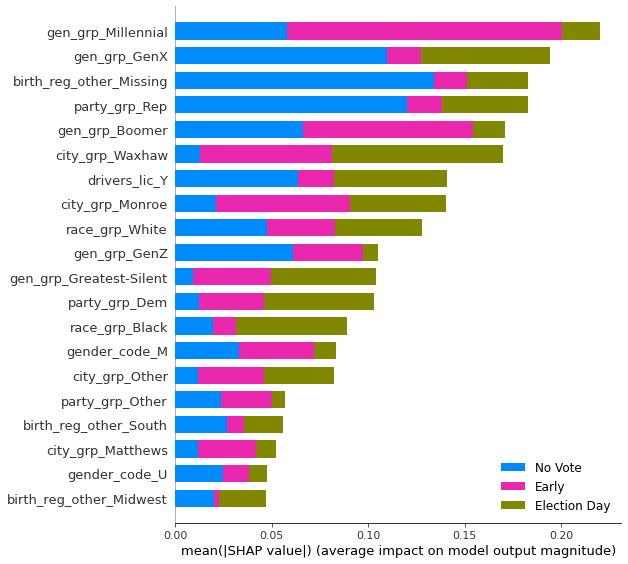

In [62]:
## Display mean abs(SHAP value) of each feature for the full training set
  ## for all classes
shap.summary_plot(multi_2020_shap_values, X_2020_train_df,
                  plot_type='bar', class_names=le_2020.classes_)

The plots that follow are similar to the above plot in that they rank the top features based on mean SHAP values, but each plot ranks the features for one of the 3 target classes ("Early", "Election Day", and then "No Vote" respectively). Each point represents a voter in the training set. The grey vertical line at 0.0 represents SHAP values that had 0 impact on model output, so the farther the points are from the grey line, the more important the feature was in terms of predicting that voter's participation in the election. Negative SHAP values to the left of the grey line push the model towards a prediction of 0 for the particular class (in other words, not the class in question), whereas positive SHAP values push the model towards a prediction of the class in question (1). 

Since all the features were label encoded, each feature is a binary variable representing whether the voter does or does not belong to the category listed at the end of the feature name (so 1 for `gen_grp_Millenial` means the person is a millennial). Thus high values of 1 are color coded red and low values of 0 are color coded blue.

---

**Top 5 Features for the "Early" Class Explained**:

1. `gen_grp_Millennial` - Being a millenial (1, red) pushed the model away from a prediction of "Early".


2. `gen_grp_Boomer` - Belonging to the Baby Boomer generation (1, red) pushed the model towards a prediction of "Early".


3. `city_grp_Monroe` - Residing in Monroe (1, red) pushed the model away from a prediction of "Early".


4. `city_grp_Waxhaw` - Residing in Waxhaw (1, red) pushed the model towards a prediction of "Early".


5. `gen_grp_Greatest-Silent` - Belonging to the Greatest/ Silent generation age group (1, red) pushed the model towards a prediction of "Early".



******************** Early Class ********************


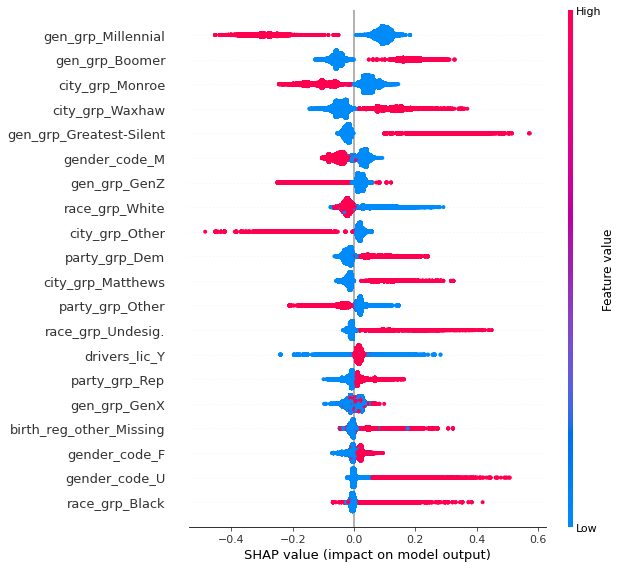

In [63]:
multi_shap_summ(multi_2020_shap_values, X_2020_train_df, 0);

---

**Top 5 Features for the "Election Day" Class Explained**:

1. `city_grp_Waxhaw` - Residing in Waxhaw (1, red) pushed the model away from a prediction of "Election Day".


2. `gen_grp_GenX` - Belonging to the Baby Boomer generation (1, red) pushed the model towards a prediction of "Election Day".


3. `drivers_lic_Y` - Not having a drivers license (0, blue) pushed the model away from a prediction of "Election Day".


4. `race_grp_Black` - Being Black (1, red) pushed the model away from a prediction of "Election Day".


5. `party_grp_Dem` - Being a Democrat pushed the model away from a prediction of "Election Day".



******************** Election Day Class ********************


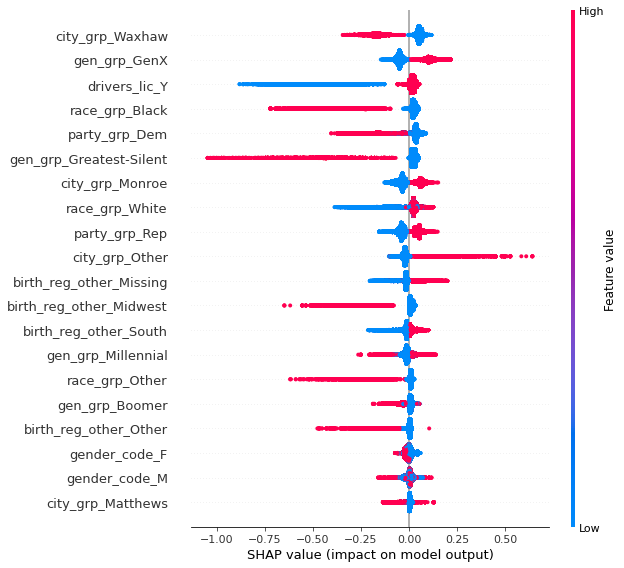

In [64]:
multi_shap_summ(multi_2020_shap_values, X_2020_train_df, 1);

---

**Top 5 Features for the "No Vote" Class Explained**:

1. `birth_reg_other_Missing` - Missing information about birthplace (1, red) pushed the model away from a prediction of "No Vote".


2. `party_grp_Rep` - Being a Republican (1, red) pushed the model away from a prediction of "No Vote" and not being a Republican (0, blue) pushed the model towards a prediction of "No Vote".


3. `gen_grp_GenX` -  Belonging to Generation X (1, red) pushed the model away from a prediction of "No Vote".


4. `gen_grp_Boomer` - Being a Baby Boomer (1, red) pushed the model away from a prediction of "No Vote".


5. `drivers_lic_Y` - Not having a drivers license (0, blue) pushed the model towards a prediction of "No Vote".



******************** No Vote Class ********************


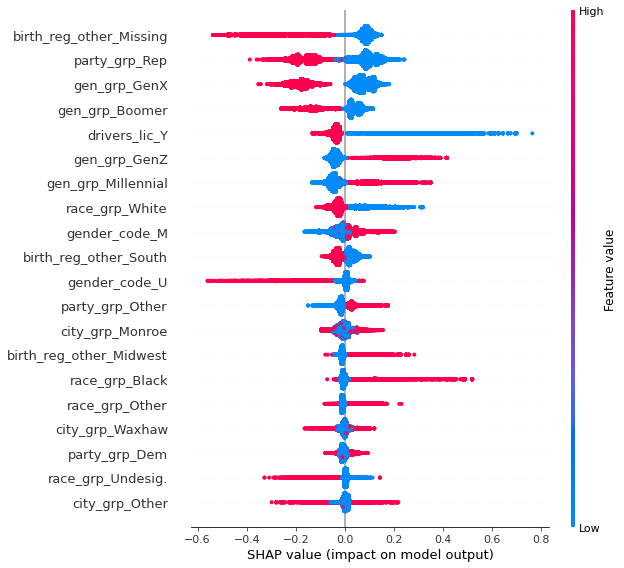

In [65]:
multi_shap_summ(multi_2020_shap_values, X_2020_train_df, 2);